# Computing the autocorrelation function (ACF)

In this notebook we show how to compute the ACF, ACF plots, and introduce a class of timeseries with particular properties known as an AR (autogregressive) process.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# Computing the ACF manually for a white noise timeseries

The autocorrelation of a timeseries $y_t$ at a lag $k$ is given by:

$$ r_k =  \frac{\sum^{t=T}_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum^{t=T}_{t=1}{(y_t - \bar{y})^2}}$$

Let's compute this manually on a time series of white noise where each observation is generated by random from a normal distribution so there is no predictive information in any historic point:

$y_t = noise_t$ where $noise_{t}  \sim  N(mean=0, std=1)$

We expect the autocorrelation to be small at all lags as each data point is completely independent of each other.

In [2]:
num_timesteps = 300  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time

y = np.random.normal(loc=0, scale=1, size=num_timesteps)
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

df = pd.DataFrame(data={"y": y}, index=ts)
df.head()

,y
2000-01-01,1.764052
2000-01-02,0.400157
2000-01-03,0.978738
2000-01-04,2.240893
2000-01-05,1.867558


Text(0.5, 0, 'Time')

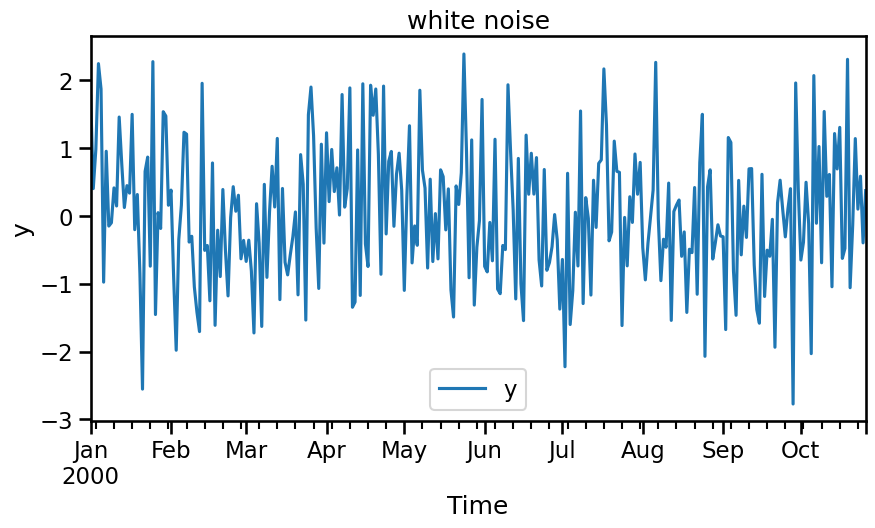

In [3]:
# Plot the time series
ax = df.plot(figsize=[10, 5])
ax.set_title("white noise")
ax.set_ylabel("y")
ax.set_xlabel("Time")

In [4]:
# Create a copy to preserve the original dataframe for later use
df_ = df.copy()

In [5]:
# Compute the lag of the target
lag = 1
df_[f"y_lag_{lag}"] = df_["y"].shift(periods=lag)
df_.head()

,y,y_lag_1
2000-01-01,1.764052,NaN
2000-01-02,0.400157,1.764052
2000-01-03,0.978738,0.400157
2000-01-04,2.240893,0.978738
2000-01-05,1.867558,2.240893


Note: It is because of the missing data introduced by the lag that we start the sum from k+1 in the numerator.

In [6]:
# Compute the numerator and denominator in the ACF formula.
y_mean = df_["y"].mean()  # Compute mean of y of the dataset.
# Numerator of the ACF formula.
numerator = ((df_["y"] - y_mean) * (df_[f"y_lag_{lag}"] - y_mean)).sum()
# Denominator of the ACF formula.
denominator = ((df_["y"] - y_mean) ** 2).sum()
# Compute the autocorrelation.
r = numerator / denominator
print(r)

-0.02964688962835345


In [7]:
# Compute the autocorrelation for multiple lags
r = {}
for lag in range(0, 37):
    df_ = df.copy()
    df_["y_lag"] = df_["y"].shift(lag)
    y_mean = df_["y"].mean()
    numerator = ((df_["y"] - y_mean) * (df_["y_lag"] - y_mean)).sum()
    denominator = ((df_["y"] - y_mean) ** 2).sum()
    r[lag] = numerator / denominator

acf_ = pd.Series(r)

In [8]:
acf_.head()

0    1.000000
1   -0.029647
2    0.051701
3    0.056755
4    0.004363
dtype: float64

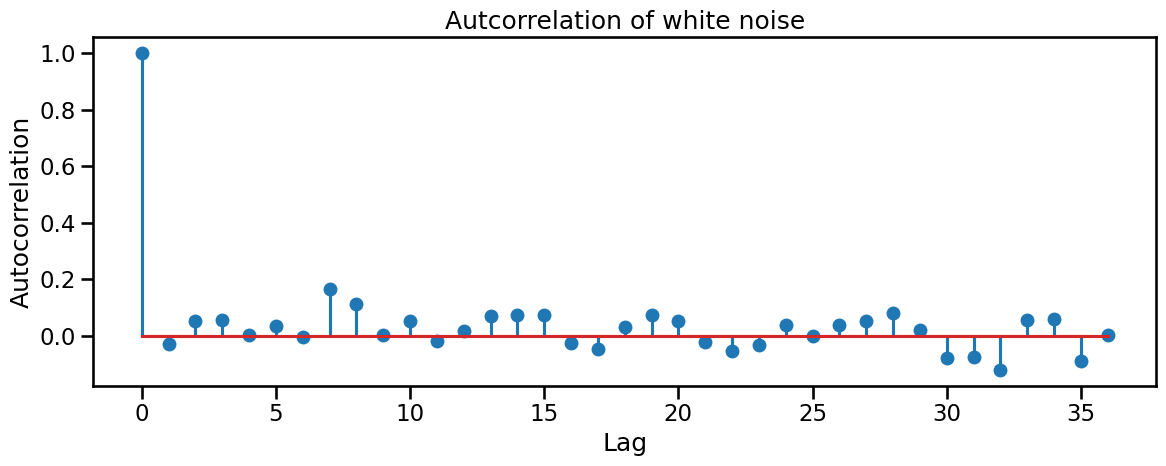

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])
plt.stem(acf_)
ax.set_title("Autcorrelation of white noise")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

# Compute the ACF for white noise using statsmodels

In [10]:
# Create a copy to preserve the original dataframe for later use
df_ = df.copy()

In [11]:
acf_ = acf(x=df_["y"], nlags=20)
acf_

array([ 1.        , -0.02964689,  0.0517005 ,  0.05675462,  0.00436303,
        0.03528042, -0.00266454,  0.16528553,  0.11264096,  0.00461414,
        0.0512451 , -0.01728878,  0.01791833,  0.06893252,  0.07320845,
        0.07403495, -0.0241931 , -0.04691654,  0.03300885,  0.07272857,
        0.05298582])

Text(0.5, 0, 'Lag')

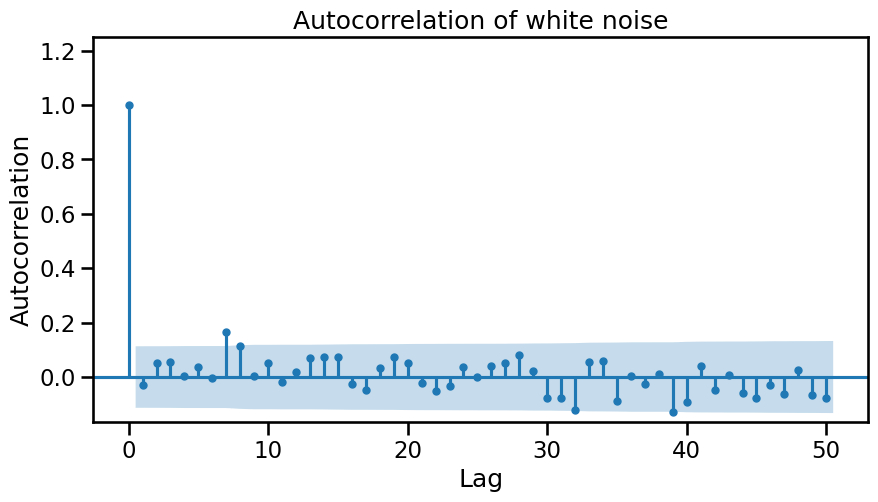

In [12]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df_["y"],
    lags=50,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
);
ax.set_title("Autocorrelation of white noise")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")

 - The autocorrelation is one at lag 0 as expected.
 - The autocorrelation at all other lags are not significant. As expected from white noise because the timeseries at each point is determined independently from each other point and therefore no point is correlated to a previous point.


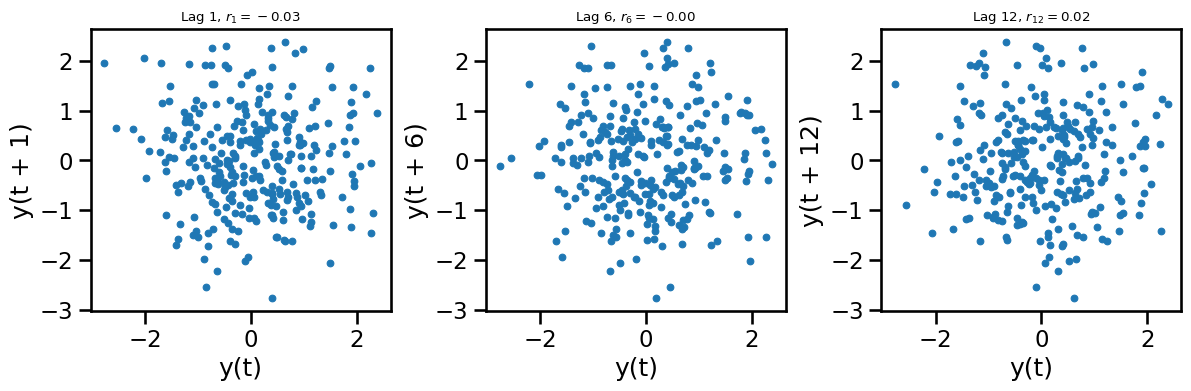

In [13]:
# Plot example lag plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

with sns.plotting_context("paper"):
    pd.plotting.lag_plot(df_["y"], lag=1, ax=ax[0])
    ax[0].set_title(f"Lag 1, $r_1={acf_[1]:.2f}$")
    ax[0].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=6, ax=ax[1])
    ax[1].set_title(f"Lag 6, $r_6={acf_[6]:.2f}$")
    ax[1].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=12, ax=ax[2])
    ax[2].set_title(f"Lag 12, $r_{{12}}={acf_[12]:.2f}$")
    ax[2].ticklabel_format(style="sci", scilimits=(0, 0))

    plt.tight_layout()

We see clearly that there is no correlation in the lag plots.

Now let's look at some timeseries with more structure and see what the ACF looks like.

# AR(1) process - a time series determined by lag 1 

We create a toy time series where there should be a correlation with lag 1 of the time series.

$$y_t = \phi_1 y_{{t-1}} + c + noise_t$$ where $$noise_{t}  \sim  N(mean=0, std=1)$$ $$|\phi_1| < 1 $$ $$c = constant$$

The above is known as an AR(1) process where AR stands for autoregressive. AR processes like this are a class of toy time series which form the basis of a lot of theory for time series analysis. We only present what we need to know for the purpose of feature engineering!

The requirement $|\phi_1| < 1$ is to ensure the timeseries is stationary (i.e., the mean and variance do not change in time). If $|\phi_1| > 1$ then $y_t$ would grow exponentially as the process went forward in time (this will be easier to see in the equations below, be patient!), which would not be a stationary behaviour. 

$c$ is just a constant that we can choose when creating an AR(1) process, for the rest of this section we'll just consider $c=0$.

We might think that this means there is only a correlation with lag 1 of the time series $y$ but we will see that is not the case. 

Let's show that we will expect some correlation with lags greater than 1 (i.e., $y_{t-k}$ where $k > 1$). To simplify the point we're going to ignore the noise component for now ($noise_t = 0$). Using the the formula above we can write:

$$y_{t-1} = \phi_1 y_{{t-2}} $$ 

and plug that back in the equation for $y_t$:

$$y_{t} = \phi_1 (\phi_1 *y_{{t-2}}) = \phi_1^2 y_{{t-2}} $$ 

we now see that where is a relationship between $y_t$ and $y_{t-2}$ with coefficient $\phi_1^2$. As $|\phi_1| < 1$ this implies that $\phi_1^2 < \phi_1$, that is, the the dependence of $y_{t-2}$ on $y_t$ is smaller than $y_{t-1}$. We can repeat this process to obtain $y_t$ in terms of any lag $y_{t-k}$:



$$y_t = \phi_1 y_{{t-1}} $$ 
$$y_t = \phi_1^2 y_{{t-2}} $$
$$y_t = \phi_1^3 y_{{t-3}} $$
$$...$$
$$y_t = \phi_1^k y_{{t-k}} $$


This shows us that we can relate $y_t$ to lagged versions of itself for lags greater than 1. We see that data further in the past gets less weight. This means that larger lags have less influence on $y_t$. This reasoning holds true even if the noise were non-zero. We shall see this decrease in influence from lags further in the past will be reflected in the ACF.

Now consider if $|\phi_1| > 1$ and look at the equations above. Given some starting point $y_0$ given $t$ steps into the future, using the above equation we get: $y_t = \phi_1^t y_0$ - this is exponential growth into the future, certainly not stationary!

Now let's generate an example of a timeseries from an AR1 process.

In [14]:
# Initial parameters
num_timesteps = 1000  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time
phi_1 = 0.9
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

# Generate time series
y = np.zeros(num_timesteps)
for t in range(1, num_timesteps):
    noise = np.random.normal()
    y[t] = phi_1 * y[t - 1] + noise

df = pd.DataFrame(data={"y": y}, index=ts)

Text(0.5, 0, 'Time')

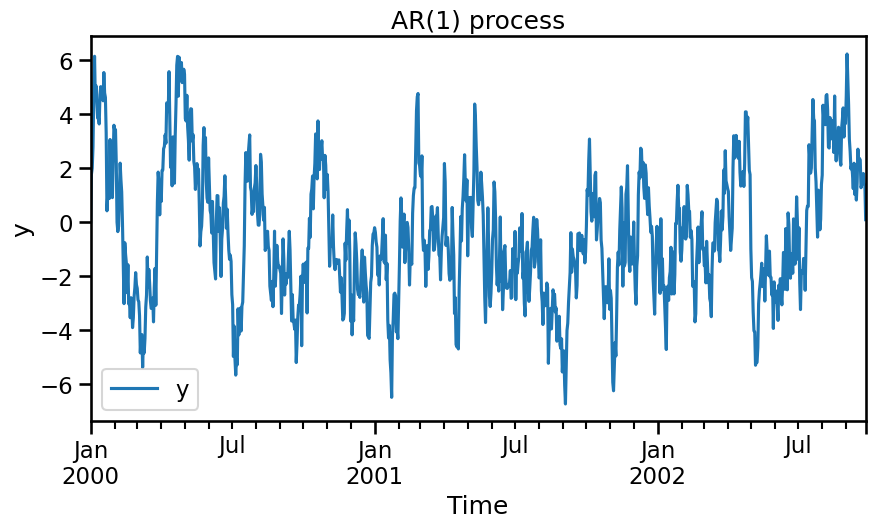

In [15]:
# Plot the time series
ax = df.plot(figsize=[10, 5])
ax.set_title("AR(1) process")
ax.set_ylabel("y")
ax.set_xlabel("Time")

Now let's plot the ACF and PACF for the timesere we generated from the AR(1) process.

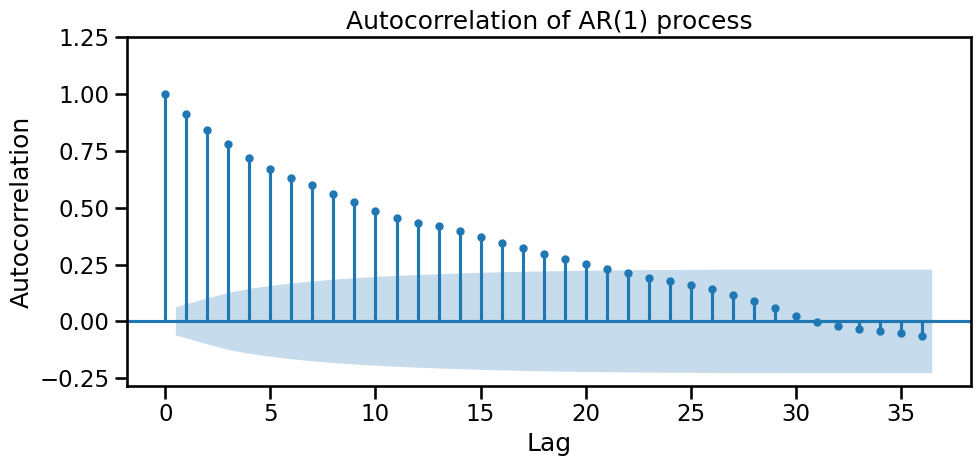

In [16]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df,
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of AR(1) process")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

As expected we can see the ACF is large and significant for many lags and we will see that it decays rapidly compared to a time series which has a trend. In fact it is possible to calculate the ACF analytically for an AR(1) process and can be shown to be: $ corr(y, y_{t-k}) = r(k) = \phi_1^k$ (i.e., exponential decay) [[1]](https://online.stat.psu.edu/stat510/lesson/1/1.2).

So we see that it is not possible to determine that only a lag of 1 that is the most important from the ACF, despite $y_t$ being generated only by $y_{t-1}$. We shall see later in this section of the course that the partial autcorrelation function (PACF) will help identify that a lag of 1 is important in this scenario.

Note: Autoregressive (AR) processes is a big topic in time series analysis. We cover only what we need to know for the purpose of feature engineering.

More generally, an AR(P) process is when $y_t$ is determined by p lags:

$$y_t = c + \phi_1 y_{{t-1}} + \phi_2 y_{{t-2}} + ... + \phi_p y_{{t-p}} + noise_t$$ where $$noise_{t}  \sim  N(mean=0, std=1)$$


For AR(1) we required $|\phi| < 1$ for the process to be stationary. The requirements for the coefficients $\phi_i$ to ensure the AR(p) process to stationary is more complex and out of scope for this course for the purpose of feature engineering.

Some useful references if you want to study AR processes in more depth would be:

1. https://online.stat.psu.edu/stat510/lesson/1/1.2
2. https://otexts.com/fpp3/AR.html
3. George, E. P. "Box. Time series analysis: forecasting and control." (1970). 
4. Brockwell and Davis, 2010. Introduction to Time Series and Forecasting, 2nd edition.


# Time series with trend and seasonality

Let's assume that we do not know that there is seasonality with period 12 (i.e., yearly) in the data. We shall show that lag plots and the ACF can help highlight the period of the seasonality and therefore suggest a useful lag (i.e., a seasonal lag with the length of the period - e.g., 12 for yearly seasonality). If we knew the seasonal period beforehand we would go ahead and just use a lag with the seasonal period.

In [17]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

Let's plot the time series

Text(0.5, 0, 'Time')

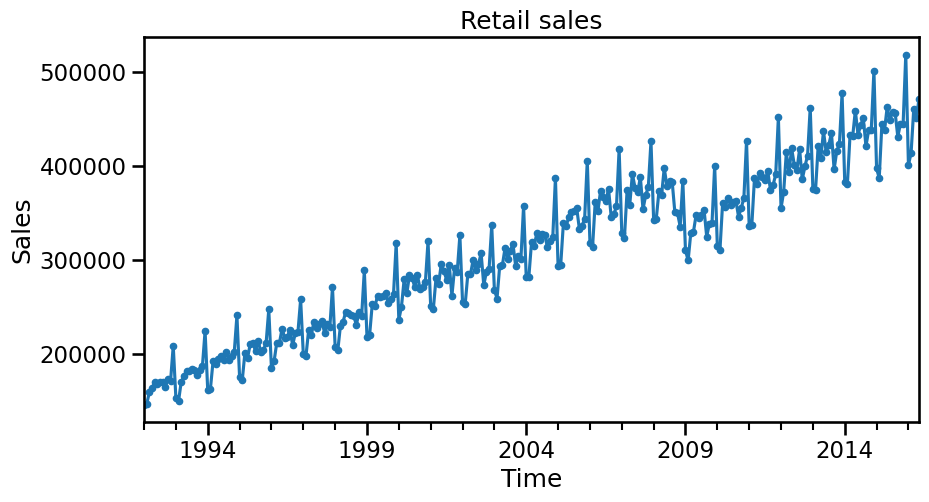

In [18]:
ax = df.plot(y="y", marker=".", figsize=[10, 5], legend=None)
ax.set_title("Retail sales")
ax.set_ylabel("Sales")
ax.set_xlabel("Time")

Let's compute the ACF and get the output as an array

In [19]:
acf_ = acf(df["y"], nlags=36)

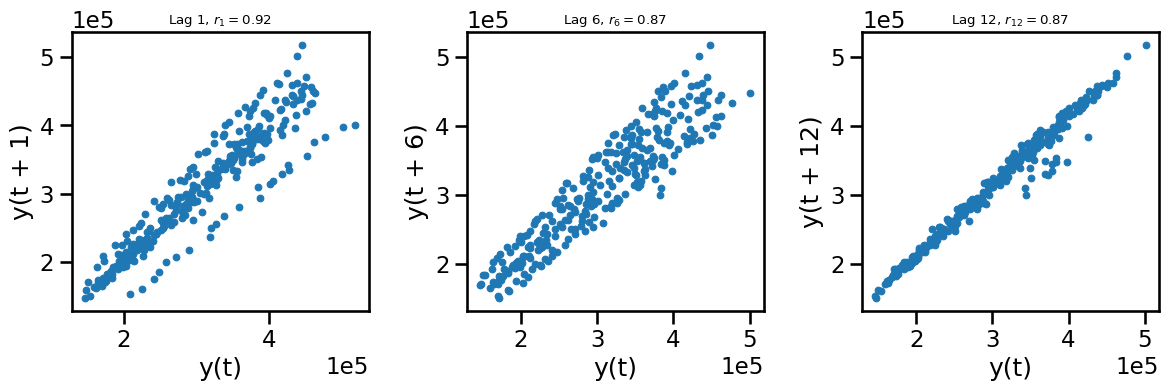

In [20]:
# Plot example lag plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

with sns.plotting_context("paper"):
    pd.plotting.lag_plot(df["y"], lag=1, ax=ax[0])
    ax[0].set_title(f"Lag 1, $r_1={acf_[1]:.2f}$")
    ax[0].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df["y"], lag=6, ax=ax[1])
    ax[1].set_title(f"Lag 6, $r_6={acf_[6]:.2f}$")
    ax[1].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df["y"], lag=12, ax=ax[2])
    ax[2].set_title(f"Lag 12, $r_{{12}}={acf_[12]:.2f}$")
    ax[2].ticklabel_format(style="sci", scilimits=(0, 0))

    plt.tight_layout()

We can see that the lag plot shows far more linear correlation at lag 12. However, in practice we may miss this when plotting many lags. The ACF allows use to condense the linear correlation in the multiple lag plots into a single plot.

Let's plot the ACF

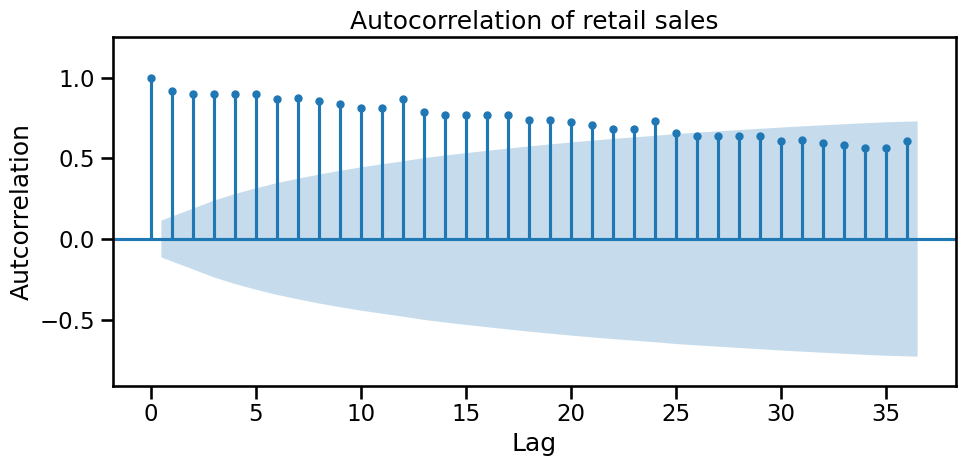

In [21]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df["y"],
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of retail sales")
ax.set_ylabel("Autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

 - The autocorrelation is one at lag 0 as expected.
 - The autocorrelation decays slowly due to the strong trend.
 - There are peaks at multiples of the lag of 12. This suggests there is seasonality with lag 12.

In summary this would suggest that we could create features using a lag of 12 (from the seasonality). If there is a strong trend component in the data then recent values (i.e., low lags) will also be helpful. So we should also consider using a lag of 1 or 2.

We see above that the trend overwhelms the ACF. We might get more information if we de-trend the data first. Let's try this.

# ACF after detrending the original series

For this example we are assuming we do not know the seasonality ahead of time. So we will use LOESS rather than STL (which requires knowing the seasonal period beforehand) to extract the trend. 

In [22]:
# Compute the trend with LOWESS
frac = 0.1
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

Text(0.5, 0, 'Time')

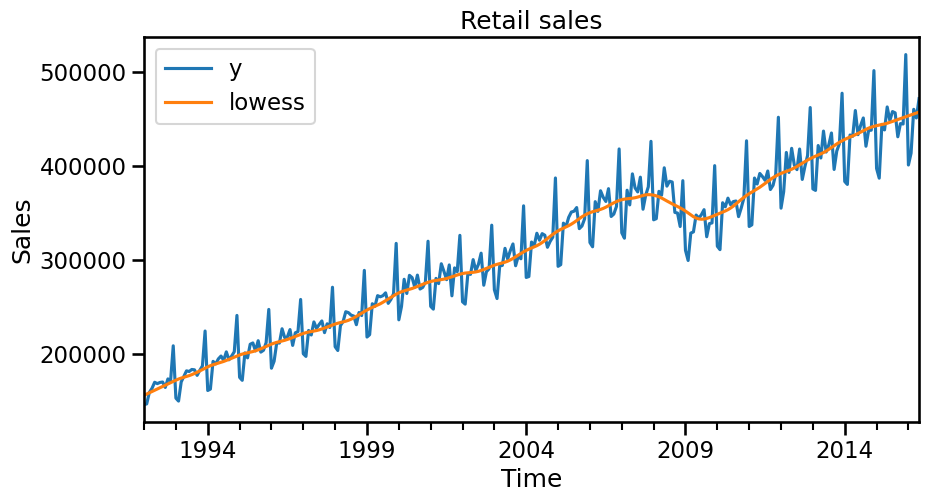

In [23]:
ax = df.plot(figsize=(10, 5))
ax.set_title("Retail sales")
ax.set_ylabel("Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

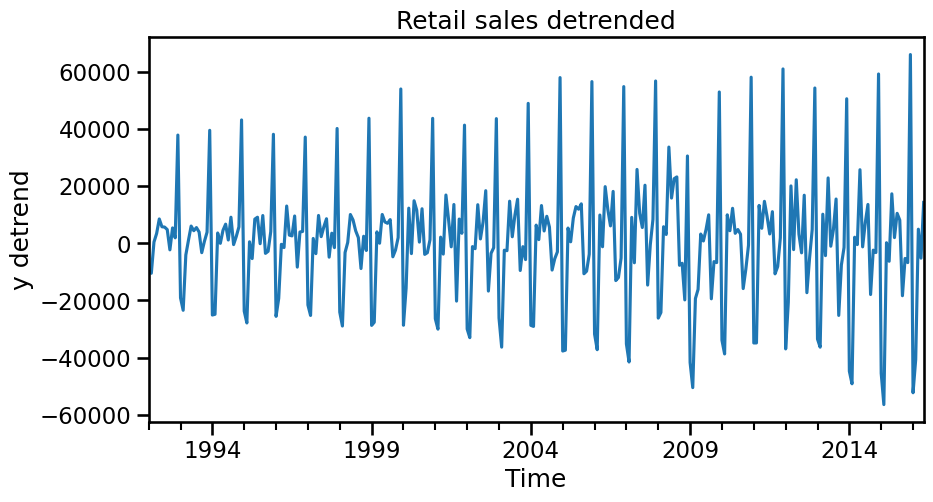

In [24]:
df["y_detrend"] = df["y"] - df["lowess"]
ax = df["y_detrend"].plot(figsize=(10, 5))
ax.set_title("Retail sales detrended")
ax.set_ylabel("y detrend")
ax.set_xlabel("Time")

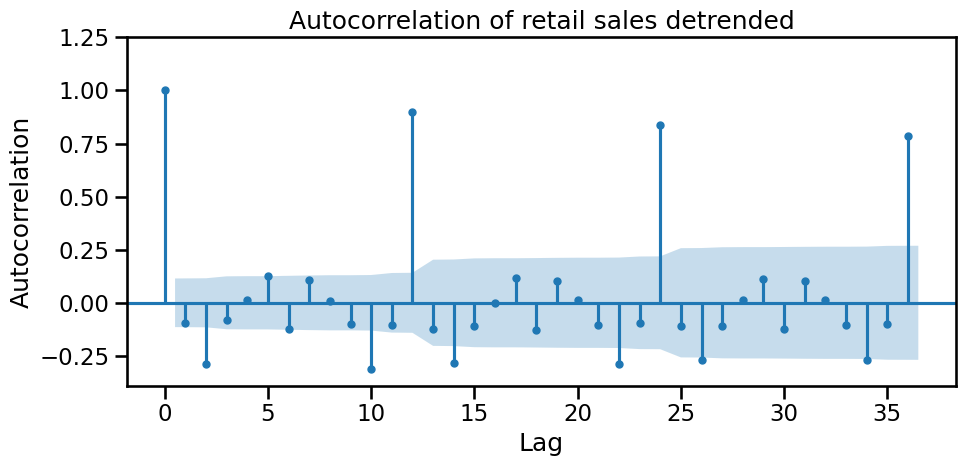

In [25]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df["y_detrend"],
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of retail sales detrended")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

 - There are peaks at multiples of the seasonal lag of 12 due to the seasonality. This is much clearer now that we have de-trended. 

You might be asking should we now look at the ACF of the trend component we extracted using LOESS? This will only be helpful if the trend ended up picking a longer term seasonality and so has some periodicity. If it does not then we don't look at the ACF of just the trend component because it will not give helpful information. A long term trend as shown in the previous section results in a long decaying ACF and doesn't help us select any useful lags. Let's show this explicitly.

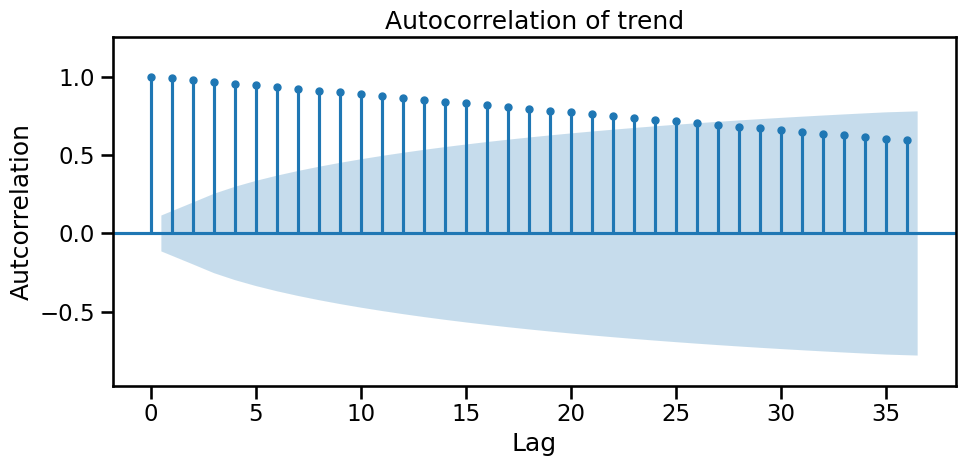

In [26]:
# Plot ACF of the trend extracted by LOWESS
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df["lowess"],
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of trend")
ax.set_ylabel("Autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

# ACF after detrending and deseasonalising

Now that we know the period of any seasonality we can remove the impact of the trend and seasonal components on the ACF to help identify useful lags. 

The retail sales example has one seasonality with period 12 so let's use STL. If the timeseries has multiple seasonal periods (e.g., daily and weekly) then use MSTL to help detrend and deseasonalise the timeseries. We will show an example with multiple seasonalities in notebook 8 of this section.

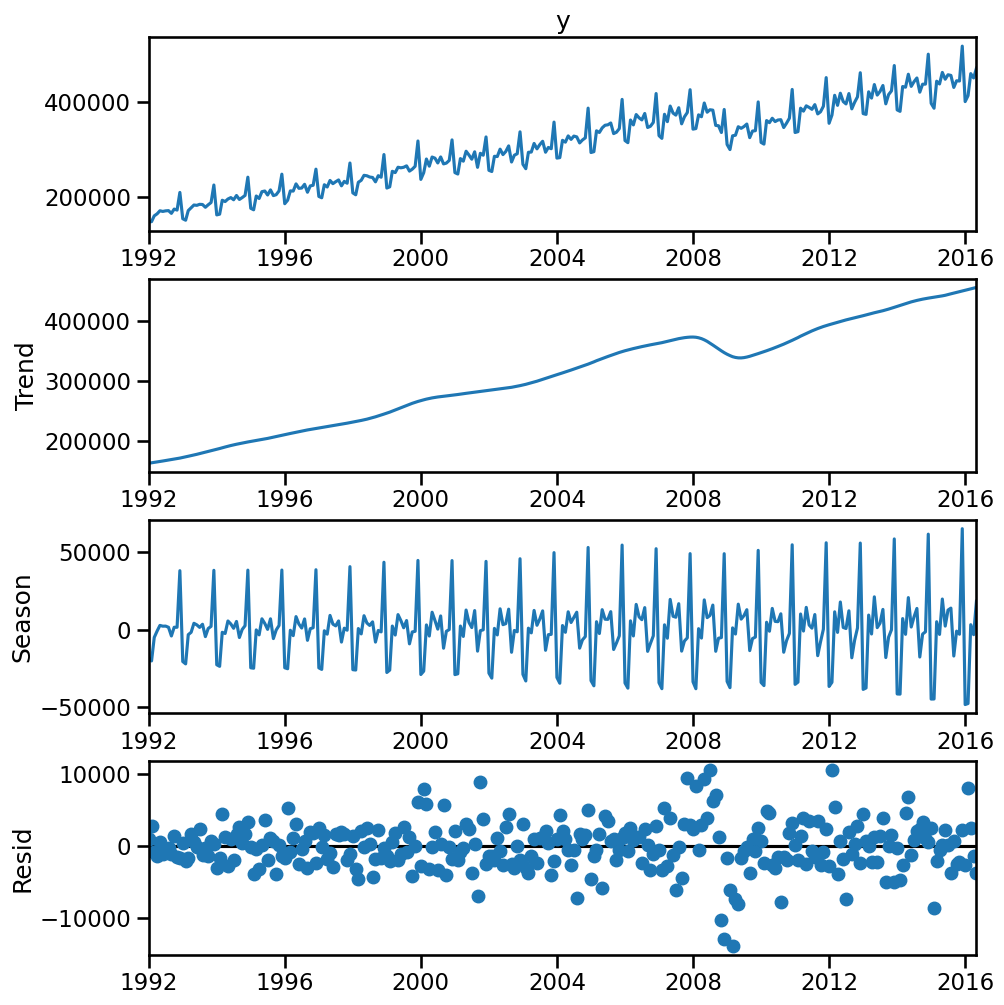

In [27]:
# Break the timeseries into trend, seasonality, and residual components
res = STL(df["y"]).fit()

# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

The residuals from STL are: $y - trend - season$. Therefore, the detrended and deaseasonalised data is equivalent to the residual component here. Let's look at the ACF.

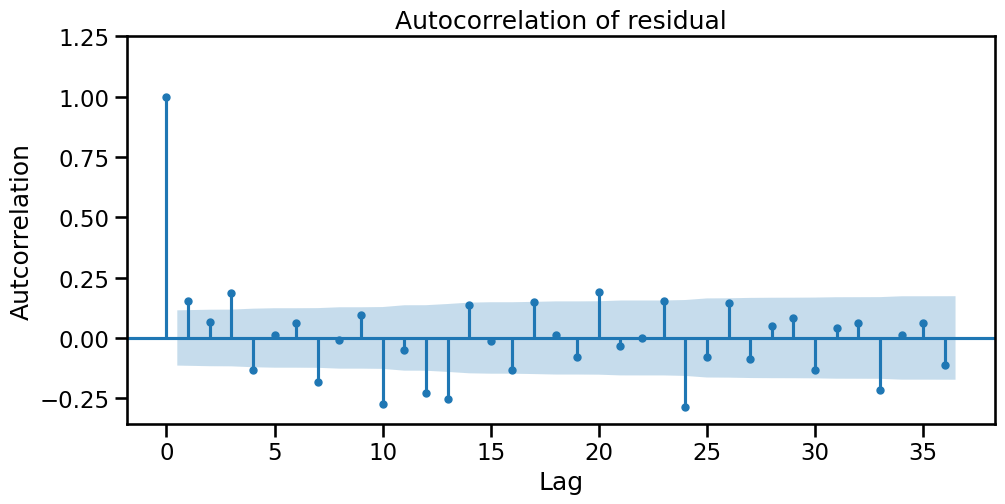

In [28]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=res.resid,
    lags=36,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
)
ax.set_title("Autocorrelation of residual")
ax.set_ylabel("Autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

We can see that there aren't any large significant lags. There appears to be some significant lags at multiples of 12 which suggests that some part of the seasonal component is still in the residuals and was not perfectly extracted by STL. Practically speaking from looking at this plot there wouldn't be an additional lag beyond 1 or 2 that we would want to add for feature engineering purposes.

That's it for this notebook! Let's move onto the partial autocorrelation function!